### Setup Libs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-io

     |████████████████████████████████| 23.4 MB 1.7 MB/s 


In [3]:
!nvidia-smi

Thu Apr  7 06:16:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow.keras.layers as L
from tensorflow.python.client import device_lib
from tensorflow.python.ops.numpy_ops import np_config
        

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

### Extracting the files from the zip to the folder

In [5]:
filePath = '/content/drive/MyDrive/Datasets/ColorDataset/ColorDataset.zip'

In [6]:
!mkdir colorDataset

In [7]:
!unzip /content/drive/MyDrive/Datasets/ColorDataset/ColorDataset.zip -d /content/colorDataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/colorDataset/content/colorDataset/95.jpg  
  inflating: /content/colorDataset/content/colorDataset/4232.jpg  
  inflating: /content/colorDataset/content/colorDataset/1880.jpg  
  inflating: /content/colorDataset/content/colorDataset/4163.jpg  
  inflating: /content/colorDataset/content/colorDataset/177.jpg  
  inflating: /content/colorDataset/content/colorDataset/764.jpg  
  inflating: /content/colorDataset/content/colorDataset/684.jpg  
  inflating: /content/colorDataset/content/colorDataset/4051.jpg  
  inflating: /content/colorDataset/content/colorDataset/3924.jpg  
  inflating: /content/colorDataset/content/colorDataset/1077.jpg  
  inflating: /content/colorDataset/content/colorDataset/2311.jpg  
  inflating: /content/colorDataset/content/colorDataset/5336.jpg  
  inflating: /content/colorDataset/content/colorDataset/2479.jpg  
  inflating: /content/colorDataset/content/colorDataset/5152.jpg  
  inflating: /co

### Global Var

In [8]:
dataset_path = '/content/colorDataset'
imgDirPath = '/content/colorDataset/content/colorDataset'
osSep = '/'
dataPath = imgDirPath + osSep + '*.jpg'

In [9]:
# image attr
img_w = 256
img_h = 256

In [10]:
np_config.enable_numpy_behavior()

##### Method to set Configuration for the tf.data.Dataset

In [11]:
def config_ds(ds, batch_size):

    # setting up the cache 
    ds = ds.cache()
    # setting up the batch_size
    ds = ds.batch(batch_size)
    # setting up the prefectch freq
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

#### Class to Clean the Dataset

In [12]:
class DatasetCleaner:
    
    '''
    Description : Class to Clean the Datasets
    '''

    # Method to remove the grayscale images from the directroy
    @staticmethod
    def removeGrayScaleFromDir(dirPath, osSep='/', fileType='*.jpg'):
        '''
        Description : 
                Method to remove any grayScale images from the directroy
        Input : 
                dirPath => Path to the image directory (dType - String)
                osSep => OS File Separator (dType - String | Defualt : backslash)
                fileType => Types of Images to read from the directory(dType - String | Default : '*.jpg') 	
        Returns : 
                List (Details of the files removed from the directory)
        '''

        print('Removing any grayScale Images from the directory.........')
        removedFileNames = []
        for id, fileName in enumerate(glob.glob(dirPath + osSep + fileType)):

            image = tf.io.read_file(fileName)
            image = tf.image.decode_jpeg(image)

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False

            if isGrayScale:
                print(f'Removing ## ID : {id} ==== ImageShape : {image.shape} ==== FileName : {fileName}')
                removedFileNames.append([id, image.shape, fileName])
                os.remove(fileName)

        return removedFileNames

    # Method to remove the grayScale images from the numpy array
    @staticmethod
    def removeGrayScaleFromNumpy(numpyArr):
        '''
        Description : 
                Method to remove any grayScale images from the numpy.array
        Input : 
                numpyArr => numpy.array consisting of images
        Returns : 
                numpy.array (Consisting of only RGB images)
                List (Details of the images removed from the numpy)
        '''
        removedImages = []

        for id, image in enumerate(numpyArr):

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False
            else:
                r = image[:,:,0]
                g = image[:,:,1]
                b = image[:,:,2]

                if r.all() == g.all() == b.all():
                    isGrayScale = True

            if isGrayScale:
                print(f'GrayScale Found ## ID : {id} ==== ImageShape : {image.shape}')
                removedImages.append([id, image.shape])

        print('Removing any grayScale Images from the numpy.array.........')
        numpyArr = np.delete(numpyArr, [dtl[0] for dtl in removedImages])

        return numpyArr, removedImages

#### Class to Load the Dataset

In [13]:
class DatasetLoader:
    '''
    Description : Class to load the Dataset
    '''

    # Method to load the dataset from the dir
    @staticmethod
    def loadDataSetFromDir(imageDataPath, isShuffle = False):
        '''
        Description : 
                Method to load the dataset from the directory
        Input :
                imageDataPath => Path to the directory where the images are located (dType - String)
                isShuffle => If the images in the dataset to be shuffled (Default - False)
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.list_files(imageDataPath, shuffle=isShuffle)
    
    # Method to load the dataset from the numpy.array
    @staticmethod
    def loadDataSetFromNumpy(numpyArr):
        '''
        Description : 
                Method to load the dataset from the numpy
        Input :
                numpyArr => numpy.array containing the data 
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.from_tensor_slices(numpyArr)

#### ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB

In [14]:
class ImageUtils:

    '''
    Description : ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB
    '''

    # Method to get the RGB images
    @staticmethod
    def getRGBData(filePath, img_width, img_height):
        '''
        Description : 
                Method to get the RGB image from the given path
        Input :
                filePath => File path to the image (dType - String)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor 
        '''
        filePath = filePath.numpy().decode('utf-8')
        image = imread(filePath)
        image = resize(image, output_shape=[img_width, img_height])         
        # resize method gives resized image along with normalization
        return image

    # Method to get the LAB images
    @staticmethod
    def getLABData(image):
        '''
        Description : 
                Method to get the LAB image from the given image
        Input :
                image => RGB Image 
        Returns :
                tf.Tensor 
        '''
        labImage = rgb2lab(image)
        return labImage


    # # Method to get the training data
    # def getTrainingData(filePath):

    #     image = tf.io.read_file(filePath)
    #     image = tf.io.decode_jpeg(image)
    #     image = tf.image.convert_image_dtype(image, tf.float32)

    #     labImage = tfio.experimental.color.rgb_to_lab(image)

    #     return tf.reshape(labImage[:,:,0], shape=[256,256,1]), labImage[:,:,1:]


    # Method to get the X(L) and Y(AB) data
    @staticmethod
    def getXYData(labImage, img_width, img_height):
        '''
        Description : 
                Method to split LAB image into L and AB channels as X and Y
        Input :
                labImage => LAB Image
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor, tf.Tensor 
        '''
        _l = tf.reshape(labImage[:,:,0], shape=[img_width,img_height,1])
        _ab = tf.reshape(labImage[:,:,1:] / 128, shape=[img_width,img_height,2])
        return _l, _ab

    # to fix the shape
    def fixup_shape(_l, _ab, w, h):
        _l.set_shape([w, h, 1])
        _ab.set_shape([w, h, 2])
        return _l, _ab

#### Mapper class to Map the given Dataset

In [15]:
class DatasetMapper:

    '''
    Description : Mapper class to map the given dataset
    '''

    # Method to get the only RGB image Dataset from the give Image File Name Dataset
    @staticmethod
    def getRGBDataset(imgFileNames_ds, img_width, img_height):
        '''
        Description : 
                Method to get the only RGB image Dataset from the give Image File Name Dataset
        Input :
                imgFileNames_ds => TensorSliceDataset (consist of the image file names)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset Shapes: (img_width, img_height, None), types: tf.float32
        '''
        return imgFileNames_ds.map(lambda x : tf.py_function(ImageUtils.getRGBData, 
                                                             [x, img_width, img_height], 
                                                             tf.float32))

    # Method to get the only LAB images from the RGB image dataset
    @staticmethod
    def getLABDataset(rgbImg_ds):
        '''
        Description : 
                Method to get the only LAB images from the RGB image dataset
        Input :
                rgbImg_ds => MapDatset (consist of the RGB images)
            
        Returns :
                MapDataset Shapes: (rgbImg_width, rgbImg_height, None), types: tf.float32
        '''
        return rgbImg_ds.map(lambda x : tf.py_function(ImageUtils.getLABData,
                                                       [x],
                                                       tf.float32))

    # Method to split the LAB Image into L(X) and AB(Y) channels
    @staticmethod
    def getXYDataset(labImg_ds, img_width, img_height):
        '''
        Description : 
                Method to split the LAB Image into L(X) and AB(Y) channels
        Input :
                labImage => MapDatset (consist of the LAB images)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset shapes: ((img_width, img_height, 1), (img_width, 2img_height56, 2)), types: (tf.float32, tf.float32)
        '''

        ds = labImg_ds.map(lambda x : tf.py_function(ImageUtils.getXYData,
                                                       [x, img_width, img_height],
                                                       [tf.float32, tf.float32]))

        return ds.map(lambda x, y : ImageUtils.fixup_shape(x, y, img_width, img_height))

#### Class contains nescessary methods to plot the RGB-LAB Images & to Visualize the Model Performance

In [16]:
class ImageVisualizer:

    '''Description : Class contains nescessary methods to plot the RGB-LAB Images & to Visualize the Model Performance'''

    # function to plot the rgb/lab/grayScale images in given range from the dataset
    def plotImages(self, img_ds, img_count):

        '''
        Description :
                Method to plot the RGB/LAB/GrayScale images in given range from the given tf.data.dataset
        Input : 
                img_ds => RGB/LAB/GrayScale image dataset (tf.data.dataset )
                count => Count of images to show from the dataset
        Returns : 
                None
        '''

        # plt.figure(figsize=(100,60))
        imgs = []

        for rgb_img in img_ds.take(img_count):
            imgs.append(rgb_img)
        imgs = np.array(imgs)

        total_img = img_count

        if total_img == 1:
            plt.imshow(imgs[0])
        else:
        
            # if there are odd no of imgs
            if total_img & 1 == 1 and total_img != 1:
                total_img -= 1
                print("Only Showing", total_img)
        
            row = total_img // 3 + total_img % 3
            col = total_img // row
            # print(row, col)
            f, axs = plt.subplots(row, col)
            # print(len(axs))
            i = 0;

            if total_img == 2:        
                for ax in axs:
                    ax.imshow(imgs[i])
                    i += 1
            else:
                for r in range(row):
                    for c in range(col):
                        axs[r,c].imshow(imgs[i])
                        i += 1

        plt.tight_layout()
        plt.show()

    # to get the single channel out of img
    def getLABSingleChannel(self, img, channel):

        '''
        Description :
                Method to get the single channel out of the LAB Image
        Input : 
                img => lab image (w * h * 3)
                channel => idx of channel from the image to return 
        Returns : 
                numpy.array (w*h*3)
        '''

        z = np.zeros(img.shape)
        if channel != 0:
            # set sum lightness
            z[:,:,0] = 100 
        z[:,:,channel] = img[:,:,channel]
        z = lab2rgb(z)
        return(z)

    # function to plot the lab channel in gray map
    def plotLABSingleChannelGrayMap (self, ax, image):

        '''
        Description :
                Method to plot the individual channels of given LAB image in grayscale
        Input : 
                ax => matplotlib.pyplot.subplot axis to plot the given image
                image => LAB image
        Returns : 
                None
        '''

        ax[1].imshow(image[:,:,0], cmap='gray')
        ax[2].imshow(image[:,:,1], cmap='gray')
        ax[3].imshow(image[:,:,2], cmap='gray')
    
    # function to show the LAB image and its all the channels
    def plotLabChannels(self, labImg, label, cmap=None):

        '''
        Description :
                Method to show the LAB image and its all the channels
        Input : 
                labImg => Single LAB Image in np.array format
                label => Label for the Image (dType : Stirng)
                cmap => To plot image in grayScale or not. By default 'None'
        Returns : 
                None
        '''

        print('LAB Image - {}'.format(label))
        fig, axes = plt.subplots(nrows=1,ncols=4)
        axes[0].imshow(labImg)
        if cmap is None:
            axes[1].imshow(self.getLABSingleChannel(labImg, 0))
            axes[2].imshow(self.getLABSingleChannel(labImg, 1))
            axes[3].imshow(self.getLABSingleChannel(labImg, 2))
        else:
            self.plotLABSingleChannelGrayMap(axes, labImg)
            
        plt.tight_layout()
        plt.show()

    # function to plot the lab images in the given range
    def plotLABImages(self, lab_ds, count_img, cmap=None):

        '''
        Description :
                Method to plot the LAB images as separate channels from the given tf.data.dataset in a given range 
        Input : 
                lab_ds => LAB image dataset (tf.data.Dataset)
                count_img => Count of images to show from the dataset
                cmap => To plot image in grayScale or not. By default 'None'
                        Values : [None,'gray']
        Returns : 
                None
        '''

        if count_img <= 0:
            print('Please given the valid img count')
        for i, lab in zip(range(count_img), lab_ds.take(count_img)):
            if cmap is None:
                self.plotLabChannels(lab.numpy(), i)
            else:
                self.plotLabChannels(lab.numpy(), i, 'gray')
            print('----------------------------------------------------')

    # Function to visualize the Model Performance and Loss
    def visualizeModelHistory(self, history):

        '''
        Description :
                Method to visualize the Model Performance and Loss
        Input : 
                history => History of Model (dict)
        Returns : 
                None
        '''

        # list all data in history
        print(history.history.keys())

        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

#### Class to Colorize the Images

In [17]:
class Colorizer:
    '''Description : Class to Colorize the images'''

    # To predict the lab channels of given image
    def __predictLAB(self, model, imgPath):

        '''
        Description :
                Method to takes RGB Image filepath, then convert it to LAB to extract the L channel and 
                predict the remaining two channels (A` & B`)
        Input : 
                model => Pretrained NN model to predict the A` and B` channels
                imgPath => RGB image file path
        Returns : 
                Tuple (L channel and Predicted AB channels)

        '''
        image = ImageUtils.getRGBData(imgPath, img_w, img_h)

        labImage = ImageUtils.getLABData(image)

        _l, _ab = ImageUtils.getXYData(labImage, img_w, img_h)
        print(f'_fn_predLAB _l Shape : {_l.numpy().shape}')
        _l = _l.numpy()
        _l = _l.reshape((1,) + _l.shape)
        print(f'_fn_predLAB _l re-Shape : {_l.shape}')
        _abPred = model.predict(_l)
        return _l, _abPred


    # To Postprocess the L and AB channel
    # i.e. merge the L and AB channel and convert them into RGB image
    def __imgPostProcess(self, _l, _ab):

        '''
        Description : 
                Method to perform the processing on the predicted images
        Input : 
                _l => L channel of the Image
                _ab => Predicted AB channel of Image
        Returns : 
                np.array (RGB Image - w * h* 3)
        '''
        w = _ab.shape[1]
        h = _ab.shape[2]
        result = np.zeros((w, h, 3))

        # de normalizing the values
        # _l *= 100
        _ab *= 128
        # merging all the channels
        result[:,:,0] = _l[0,:,:,0] 
        result[:,:,1:] = _ab[0,:,:,:]


        result = result.astype('float32')
        # print(result)
        print(result.shape)

        # converting the colorspace into rgb using opencv
        # rgb = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

        # converting the colorspace into rgb using skimage
        # rgb = lab2rgb(result)

        # chaning down
        
        result = tf.convert_to_tensor(result)
        # print(result)

        rgb = tfio.experimental.color.lab_to_rgb(result)
        rgb = rgb.numpy()

        # ########
        
        print(rgb.shape)
        return np.array(rgb)

    # To predict the RGB Images from given images
    def predictRGB(self, model, img):
        
        '''
        Description : 
                Method to predict the RGB Image 
        Input : 
                model => Pretrained NN model to predict the A` and B` channels
		        img => RGB image (w * h * 3)
        Returns : 
                np.array (RGB Image - w * h* 3)
        '''
        _l, predAB = self.__predictLAB(model,img) 
        print(_l.shape)
        print(predAB.shape)
        rgbImage = self.__imgPostProcess(_l, predAB)
        return np.array(rgbImage)

### File Count of the gcDataset

In [18]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files : {total_files}')

Total JPG Files : 5900


### Removing the any Grayscale Images from the dir

In [ ]:
rmFileList = DatasetCleaner.removeGrayScaleFromDir(imgDirPath)
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')
print(f'Total Count of the removed grayScale images : {len(rmFileList)}')    

Removing any grayScale Images from the directory.........
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Total Count of the removed grayScale images : 0


In [ ]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files in the Directroy : {total_files}')

Total JPG Files in the Directroy : 5900


### Creating the tf Data Pipeline 

#### Using the tf.data.Dataset for data pipelining

In [436]:
# reading the all images from the folder
image_ds = DatasetLoader.loadDataSetFromDir(dataPath).take(100)

In [437]:
# displaying the first three data Tensors
for data in image_ds.take(2):
    print(data)

tf.Tensor(b'/content/colorDataset/content/colorDataset/0.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/colorDataset/content/colorDataset/1.jpg', shape=(), dtype=string)


#### No of Images in the Dataset

In [438]:
total_imgs = len(image_ds)
print(f'Size of image_ds : {total_imgs}')

Size of image_ds : 100


#### Setting the train-test-validation dataset size

In [439]:
train_size = int(total_imgs * 0.8)
val_size = int(total_imgs * 0.1)
test_size = int(total_imgs - train_size - val_size)
print(f'Train Size : {train_size}')
print(f'Test Size : {test_size}')
print(f'Val Size : {val_size}')

Train Size : 80
Test Size : 10
Val Size : 10


#### Splitting into train-test-validation

In [ ]:
# taking the train-test-val data
train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size + val_size)

In [ ]:
print(f'train_ds Size : {len(train_ds)}')
print(f'val_ds Size : {len(val_ds)}')
print(f'test_ds Size : {len(test_ds)}')

train_ds Size : 80
val_ds Size : 10
test_ds Size : 10


#### Setting up the Data Pipeline for the train-test-val

##### Mapping the datasets for training


In [ ]:
# getting the RGB Images dataset from the Original Dataset
train_rgb_ds = DatasetMapper.getRGBDataset(train_ds, img_w, img_h)

In [ ]:
# getting the LAB Images dataset from the collected RGB Dataset
train_lab_ds = DatasetMapper.getLABDataset(train_rgb_ds)

In [ ]:
# getting the data to train model i.e L(X) & AB(Y) channels from the collected LAB Dataset
trainData = DatasetMapper.getXYDataset(train_lab_ds, img_w, img_h)

In [ ]:
train_rgb_ds

<MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>

In [ ]:
train_lab_ds

<MapDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>

In [ ]:
trainData

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 2), dtype=tf.float32, name=None))>

Checking the each Dataset Image shapes

In [ ]:
for rgb in train_rgb_ds.take(1):
    print(f'RGB Image Shape : {rgb.shape}')

RGB Image Shape : (256, 256, 3)


In [ ]:
for lab in train_lab_ds.take(1):
    print(f'Lab Image Shape : {lab.shape}')

Lab Image Shape : (256, 256, 3)


In [ ]:
for _l, _ab in trainData.take(1):
    print('L Shape : ',_l.numpy().shape)
    print('AB Shape : ',_ab.numpy().shape)

L Shape :  (256, 256, 1)
AB Shape :  (256, 256, 2)


Visualization of Training Dataset

In [ ]:
visual = ImageVisualizer()

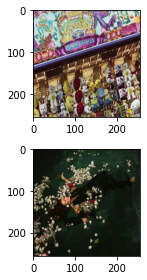

In [ ]:
visual.plotImages(train_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


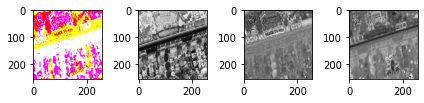

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


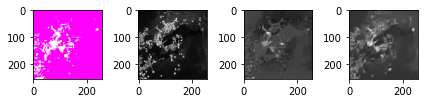

----------------------------------------------------


In [ ]:
visual.plotLABImages(train_lab_ds, 2, cmap='gray')

##### Mapping the datasets for testing


In [ ]:
# getting the RGB Images dataset from the testing Dataset
test_rgb_ds = DatasetMapper.getRGBDataset(test_ds, img_w, img_h)

In [ ]:
# getting the LAB Images dataset from the collected testing RGB Dataset
test_lab_ds = DatasetMapper.getLABDataset(test_rgb_ds)

In [ ]:
# getting the data to test model i.e L(X) & AB(Y) channels from the collected LAB Dataset
testData = DatasetMapper.getXYDataset(test_lab_ds, img_w, img_h)

Checking the each Dataset Image shapes

In [ ]:
for rgb in test_rgb_ds.take(1):
    print('RGB Images Shape :', rgb.shape)

RGB Images Shape : (256, 256, 3)


In [ ]:
for lab in test_lab_ds.take(2):
    print('LAB Images Shape :', lab.shape)

LAB Images Shape : (256, 256, 3)
LAB Images Shape : (256, 256, 3)


In [ ]:
for _l, _ab in testData.take(1):
    print('L Shape : ',_l.numpy().shape)
    print('AB Shape : ',_ab.numpy().shape)

L Shape :  (256, 256, 1)
AB Shape :  (256, 256, 2)


Visualization of Testing Dataset

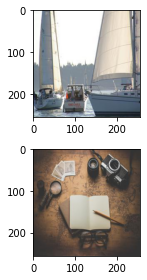

In [ ]:
visual.plotImages(test_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


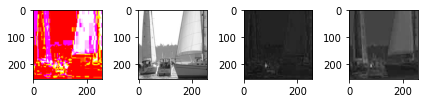

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


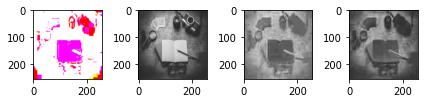

----------------------------------------------------


In [ ]:
visual.plotLABImages(test_lab_ds, 2, cmap='gray')

##### Mapping the datasets for validation


In [ ]:
# getting the RGB Images dataset from the Original Validation Dataset
val_rgb_ds = DatasetMapper.getRGBDataset(val_ds, img_w, img_h)

In [ ]:
# getting the LAB Images dataset from the collected Validation RGB Dataset
val_lab_ds = DatasetMapper.getLABDataset(val_rgb_ds)

In [ ]:
# getting the data to validate model i.e L(X) & AB(Y) channels from the collected LAB Dataset
valData = DatasetMapper.getXYDataset(val_lab_ds, img_w, img_h)

Checking the each Dataset Image shapes

In [ ]:
for rgb in val_rgb_ds.take(1):
    print('RGB Images Shape :', rgb.shape)

RGB Images Shape : (256, 256, 3)


In [ ]:
for lab in val_lab_ds.take(2):
    print('LAB Images Shape :', lab.shape)

LAB Images Shape : (256, 256, 3)
LAB Images Shape : (256, 256, 3)


In [ ]:
for _l, _ab in valData.take(1):
    print('L Shape : ',_l.numpy().shape)
    print('AB Shape : ',_ab.numpy().shape)

L Shape :  (256, 256, 1)
AB Shape :  (256, 256, 2)


Visualization of Testing Dataset

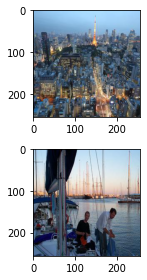

In [ ]:
visual.plotImages(val_rgb_ds, 2)

Plotting the LAB Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


LAB Image - 0


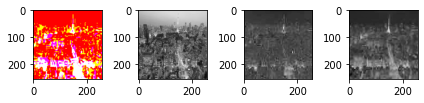

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----------------------------------------------------
LAB Image - 1


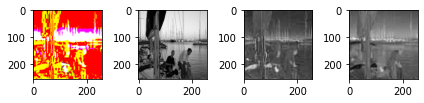

----------------------------------------------------


In [ ]:
visual.plotLABImages(val_lab_ds, 2, cmap='gray')

#### Setting up the configuration for train-test-val dataset

In [ ]:
# setting the batch size of the input dataset
batchSize = 32                           

In [ ]:
trainData = config_ds(trainData, batchSize)
testData = config_ds(testData, batchSize)
valData = config_ds(valData, batchSize)

### Creating the Autoencoder Model

#### Model Variables

In [20]:
# model variables
input_shape = (256,256,1)           # input shape of the nn
num_epochs = 500                    # no of epochs to train  the model

# optimizers for the model 
optimizerFn = tf.keras.optimizers.SGD()

# loss for model evaluation
lossFn = tf.keras.losses.CategoricalCrossentropy()

modelFileName = 'Colorizer_ResidualAutoEncoder_100_500'
#  defining the model save / load path 
model_path = '/content/drive/MyDrive/Image Colorization/model-history/div-pascal-models/models/' + modelFileName + '.h5'

# defining the history of model save / load path
history_path = '/content/drive/MyDrive/Image Colorization/model-history/div-pascal-models/history' + modelFileName + '.csv'

#### AutoEncoder NN Architecture

In [ ]:
def residualBlock(input, filterSize, kernelSize, stride, lname):

    # sending the l1 to the residual block

    r1 = L.Conv2D(filters=filterSize, kernel_size=kernelSize, strides=stride, activation='relu', padding='same', name=lname+'-r1')(input)
    r2 = L.Conv2D(filters=filterSize, kernel_size=kernelSize, strides=stride, activation='relu', padding='same', name=lname+'-r2')(r1)
    r3 = L.Conv2D(filters=filterSize, kernel_size=kernelSize, strides=stride, activation='relu', padding='same', name=lname+'-r3')(r2)

    # adding the skip connection 
    skip = L.concatenate([r1, r3], axis=3, name=lname+'-concat')

    x = L.Conv2D(filters=filterSize, kernel_size=kernelSize, strides=stride, activation='relu', padding='same', name=lname+'-x')(skip)
    
    # batch normalizaiton 
    bn = L.BatchNormalization(name=lname+'-norm')(x)

    return bn

In [ ]:
def autoEncoder(inputShape=input_shape):

    # input layer
    input_L = L.Input(shape=inputShape, name='input_layer')
    
    # Encoder Blocks

    # encoding block 1
    e1 = L.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='c-e1')(input_L)
    e_res1 = residualBlock(e1, 32, (3,3), (1,1), 'eb1')

    # encoding block 2 
    e2 = L.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='c-e2')(e_res1)
    e_res2 = residualBlock(e2, 64, (3,3), (1,1), 'eb2')

    # encoding block 3 
    e3 = L.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='c-e3')(e_res2)
    e_res3 = residualBlock(e3, 128, (3,3), (1,1), 'eb3')

    # encoding block 4 
    e4 = L.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', name='c-e4')(e_res3)
    e_res4 = residualBlock(e4, 256, (3,3), (1,1), 'eb4')


    # Bottleneck
    latent = L.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', name='latent')(e_res4)
    e_res5 = residualBlock(latent, 512, (3,3), (1,1), 'res-latent')  


    # Decoding Blocks

    # decoding block 1
    d1 = L.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='ct-d1')(e_res5)
    d_res1 = residualBlock(d1, 256, (3,3), (1,1), 'db1')
    skip1 = L.concatenate([d_res1, e4], axis=3)

    # decoding block 2
    d2 = L.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name='ct-d2')(skip1)
    d_res2 = residualBlock(d2, 128, (3,3), (1,1), 'db2')
    skip2 = L.concatenate([d_res2, e3], axis=3)
    
    # decoding block 3
    d3 = L.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name='ct-d3')(skip2)
    d_res3 = residualBlock(d3, 64, (3,3), (1,1), 'db3')
    skip3 = L.concatenate([d_res3, e2], axis=3)
    
    # decoding block 4
    d4 = L.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', name='ct-d4')(skip3)
    d_res4 = residualBlock(d4, 32, (3,3), (1,1), 'db4')
    skip4 = L.concatenate([d_res4, e1], axis=3)

    # output layer
    output_L = L.Conv2DTranspose(filters=2, kernel_size=(3,3), strides=(2,2), padding='same', activation='tanh', name='output_L')(skip4)
    

    return tf.keras.models.Model(inputs=input_L, outputs=output_L)


In [ ]:
model = autoEncoder()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 c-e1 (Conv2D)                  (None, 128, 128, 32  320         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 eb1-r1 (Conv2D)                (None, 128, 128, 32  9248        ['c-e1[0][0]']                   
                                )                                                           

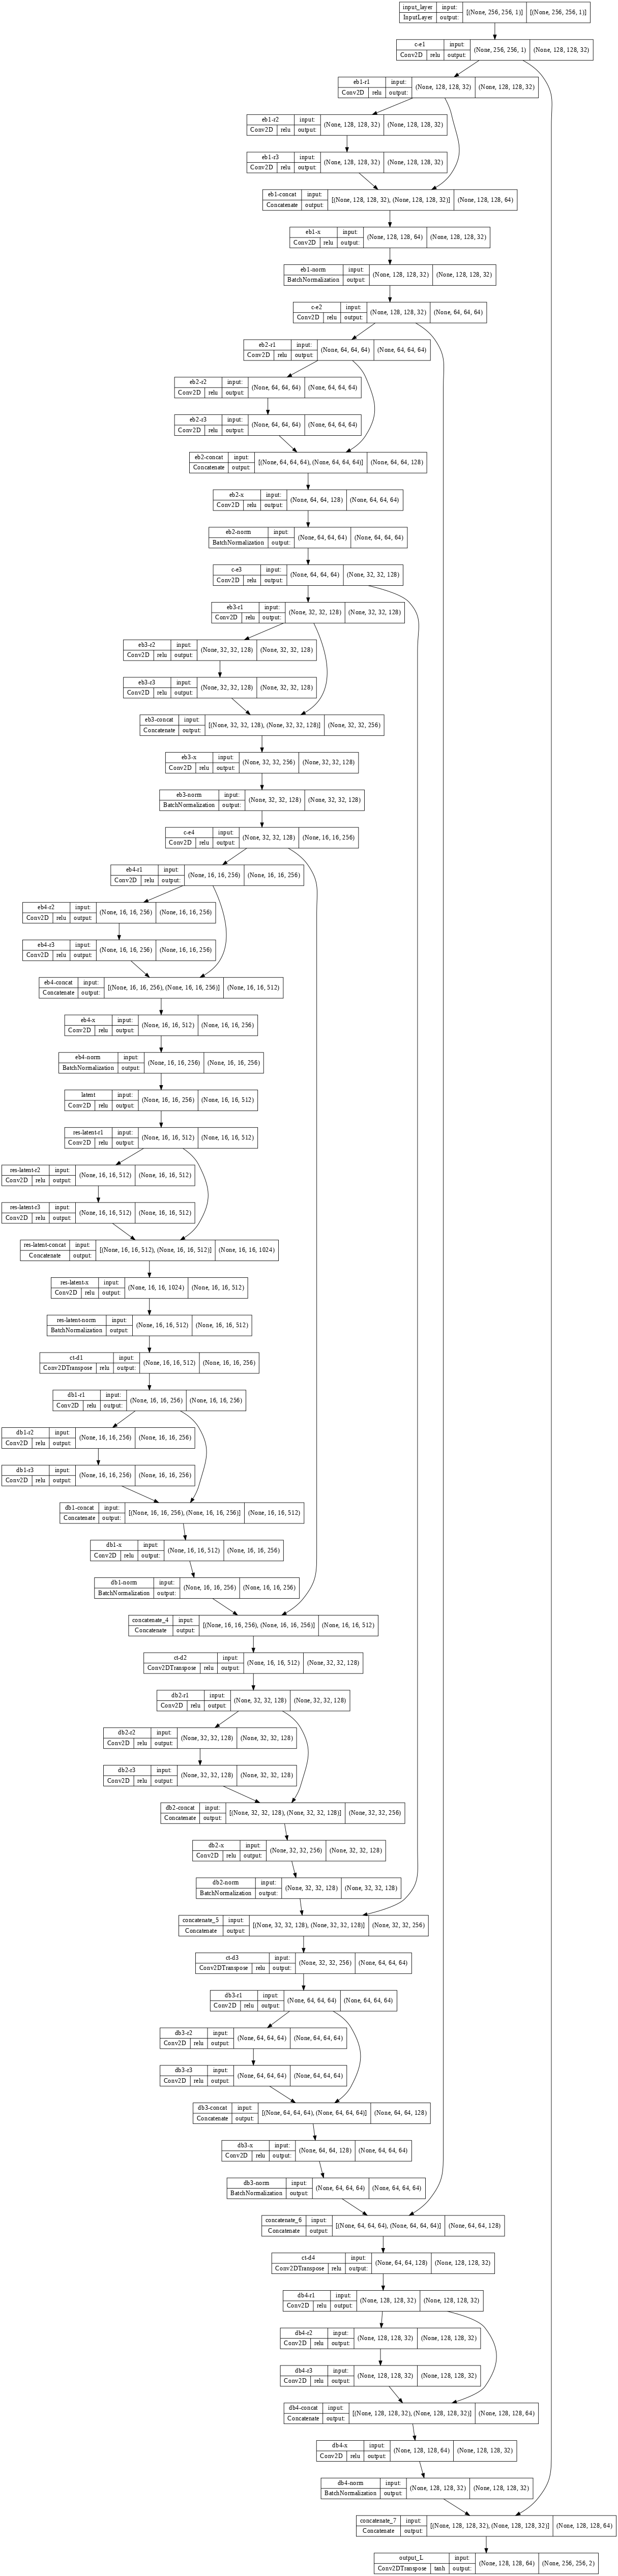

In [ ]:
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=64, show_layer_activations=True
)

### Training the Model

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Epoch 1/500
3/3 [==============================] - 11s 1s/step - loss: 0.5089 - accuracy: 0.5220 - val_loss: 0.6605 - val_accuracy: 0.5037
Epoch 2/500
3/3 [==============================] - 3s 784ms/step - loss: 0.3619 - accuracy: 0.4613 - val_loss: 1.0020 - val_accuracy: 0.4783
Epoch 3/500
3/3 [==============================] - 2s 786ms/step - loss: 0.2901 - accuracy: 0.4764 - val_loss: 1.0140 - val_accuracy: 0.4769
Epoch 4/500
3/3 [==============================] - 2s 784ms/step - loss: 0.2787 - accuracy: 0.4754 - val_loss: 1.0122 - val_accuracy: 0.4759
Epoch 5/500
3/3 [==============================] - 2s 785ms/step - loss: 0.2523 - accuracy: 0.4705 - val_loss: 1.0101 - val_accuracy: 0.4753
Epoch 6/500
3/3 [==============================] - 2s 784ms/step - loss: 0.2204 - accuracy: 0.4781 - val_loss: 1.0060 - val_accuracy: 0.4733
Epoch 7/500
3/3 [==============================] - 2s 785ms/step - loss: 0.1788 - accuracy: 0.5087 - val_loss: 1.0014 - val_accuracy: 0.4793
Epoch 8/500
3/3

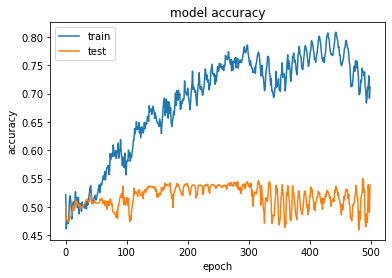

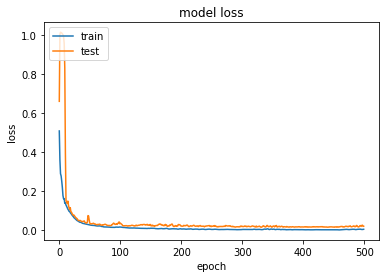

In [ ]:
# training the model

# timer
# starting the timer
start = time.time()

history = model.fit(trainData, validation_data=valData, epochs=num_epochs)

# ending the timer
end = time.time()

temp = end-start
print(f'Total Time in Seconds : {temp} sec')
hours = temp//3600
temp = temp - 3600*hours
minutes = temp//60
seconds = temp - 60*minutes
print('Total Time Taken : ')
print('HH:MM:SS => %d:%d:%d' %(hours,minutes,seconds))


model.save(model_path)          # saving the model

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
with open(history_path, mode='w') as f:
    hist_df.to_csv(f)
visual.visualizeModelHistory(history)

### Trying to Predict the Results

#### Loading the Model

In [21]:
# loading the model
newModel = keras.models.load_model(model_path)

#### Predict

In [424]:
# fileName = '/content/colorDataset/content/colorDataset/2999.jpg'
fileName = '/content/test15.jpg'

In [425]:
imgFile = tf.convert_to_tensor(fileName)

In [426]:
Ximg = ImageUtils.getRGBData(imgFile, img_w, img_h)

In [427]:
rgbResult = Colorizer().predictRGB(newModel, imgFile)

_fn_predLAB _l Shape : (256, 256, 1)
_fn_predLAB _l re-Shape : (1, 256, 256, 1)
(1, 256, 256, 1)
(1, 256, 256, 2)
(256, 256, 3)
(256, 256, 3)


In [428]:
rgbResult = rgbResult.reshape((1,) + rgbResult.shape )

---- original -----


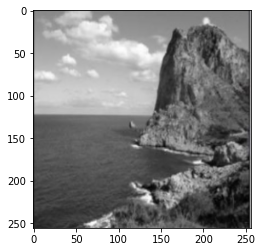

In [429]:
print('---- original -----')
plt.imshow(Ximg)

---- grayScale -----


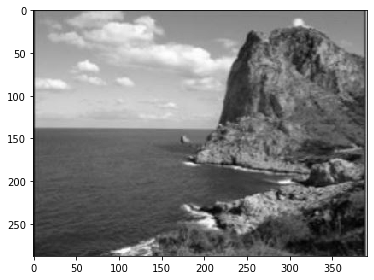

In [430]:
print('---- grayScale -----')
imshow(gray2rgb(rgb2gray(imread(fileName))))

---- predict -----


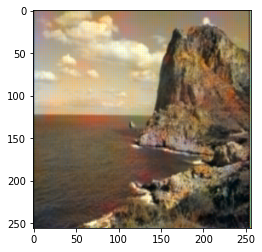

In [431]:
print('---- predict -----')
plt.imshow(rgbResult[0])